## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Downloading Data from Drive

In [ ]:
!gdown 18T123hJ3qT3QTDqeeJlY07JtJa6vnqVv

Downloading...
From (original): https://drive.google.com/uc?id=18T123hJ3qT3QTDqeeJlY07JtJa6vnqVv
From (redirected): https://drive.google.com/uc?id=18T123hJ3qT3QTDqeeJlY07JtJa6vnqVv&confirm=t&uuid=c3667b80-a744-49cb-aa6a-d4e9298746b7
To: /content/archive.zip
100% 42.6M/42.6M [00:01<00:00, 23.9MB/s]


In [ ]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: drugsComTest_raw.csv    
  inflating: drugsComTrain_raw.csv   


## Data Preprocessing

### Intializing datasets


In [ ]:
import pandas as pd # Reading Csv files

In [ ]:
# Intializing both training and test datasets
train_df = pd.read_csv("/content/drugsComTrain_raw.csv")
test_df = pd.read_csv("/content/drugsComTest_raw.csv")

# Combining Both datasets for reccomendation model
Data_df = pd.concat((train_df,test_df),ignore_index=False,sort=False)

# Removing the coloumns that are not needed for training model
train_df = train_df.drop(['uniqueID','drugName','condition','date','usefulCount'],axis=1)
test_df = test_df.drop(['uniqueID','drugName','condition','date','usefulCount'],axis=1)

In [ ]:
train_df.head()

,review,rating
0,"""It has no side effect, I take it in combinati...",9
1,"""My son is halfway through his fourth week of ...",8
2,"""I used to take another oral contraceptive, wh...",5
3,"""This is my first time using any form of birth...",8
4,"""Suboxone has completely turned my life around...",9


### Data Cleaning

In [ ]:
import nltk
import string # Used for cleaning punctuation
from gensim.parsing.preprocessing import remove_stopwords #used to remove stop words (unlike nltk it considers however as a stopword)
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup # Used for Removing HTML tags
#Downloading Word datasets used in lemmatization
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess(data):
   lemmatizer = WordNetLemmatizer()
   temptxt = BeautifulSoup(data, 'html.parser').get_text()

   temptxt= temptxt.translate(str.maketrans('', '', string.punctuation)) #Removes punctuations from string

   temptxt= temptxt.lower() #Applies lowercase to the entire review string

   temptxt= remove_stopwords(temptxt) #Removes stopwords from the review string

   temptxt= temptxt.replace('"', '')# Removing double qoutes

   word_list = word_tokenize(temptxt) #Transforms review from String to a 1d array where each word is an element to lemmatize seperatly
   clean_words= ' '.join([lemmatizer.lemmatize(w) for w in word_list])

   return clean_words




# Applying Preprocessing fucntion to both training and test datasets
train_df['review'] = train_df['review'].apply(preprocess)
test_df['review'] = test_df['review'].apply(preprocess)


<ipython-input-8-f356c5edd879>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  temptxt = BeautifulSoup(data, 'html.parser').get_text()
<ipython-input-8-f356c5edd879>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  temptxt = BeautifulSoup(data, 'html.parser').get_text()


### Labeling process

In [ ]:
# Function to add label to Datasets
def labeling_sentiment(rating):
  if 10>=rating>=7:
    label="Great"
  elif 7>rating>3:
    label="Average"
  else:
    label="Horrible"
  return label

train_df["Sentiment"]=train_df["rating"].apply(labeling_sentiment)

test_df["Sentiment"]=test_df["rating"].apply(labeling_sentiment)

In [ ]:
train_df.head()

,review,rating,Sentiment
0,effect combination bystolic 5 mg fish oil,9,Great
1,son halfway fourth week intuniv concerned bega...,8,Great
2,oral contraceptive 21 pill cycle happy light p...,5,Average
3,time form birth control im glad went patch 8 m...,8,Great
4,suboxone completely turned life feel healthier...,9,Great


In [ ]:
# Get all unique Sentiment labels
unique_labels = train_df.Sentiment.unique()

value_pair= {}
for i in range(0,len(unique_labels)):
  value_pair[unique_labels[i]]=i

value_pair

{'Great': 0, 'Average': 1, 'Horrible': 2}

In [ ]:
# Function to add label to Datasets
def labeling(condition):
  label=value_pair[condition]
  return label

train_df["label"]=train_df["Sentiment"].apply(labeling)

test_df["label"]=test_df["Sentiment"].apply(labeling)

In [ ]:
train_df = train_df.drop(['rating'],axis=1)
test_df = test_df.drop(['rating'],axis=1)

In [ ]:
train_df.head()

,review,Sentiment,label
0,effect combination bystolic 5 mg fish oil,Great,0
1,son halfway fourth week intuniv concerned bega...,Great,0
2,oral contraceptive 21 pill cycle happy light p...,Average,1
3,time form birth control im glad went patch 8 m...,Great,0
4,suboxone completely turned life feel healthier...,Great,0


### Data Visualization

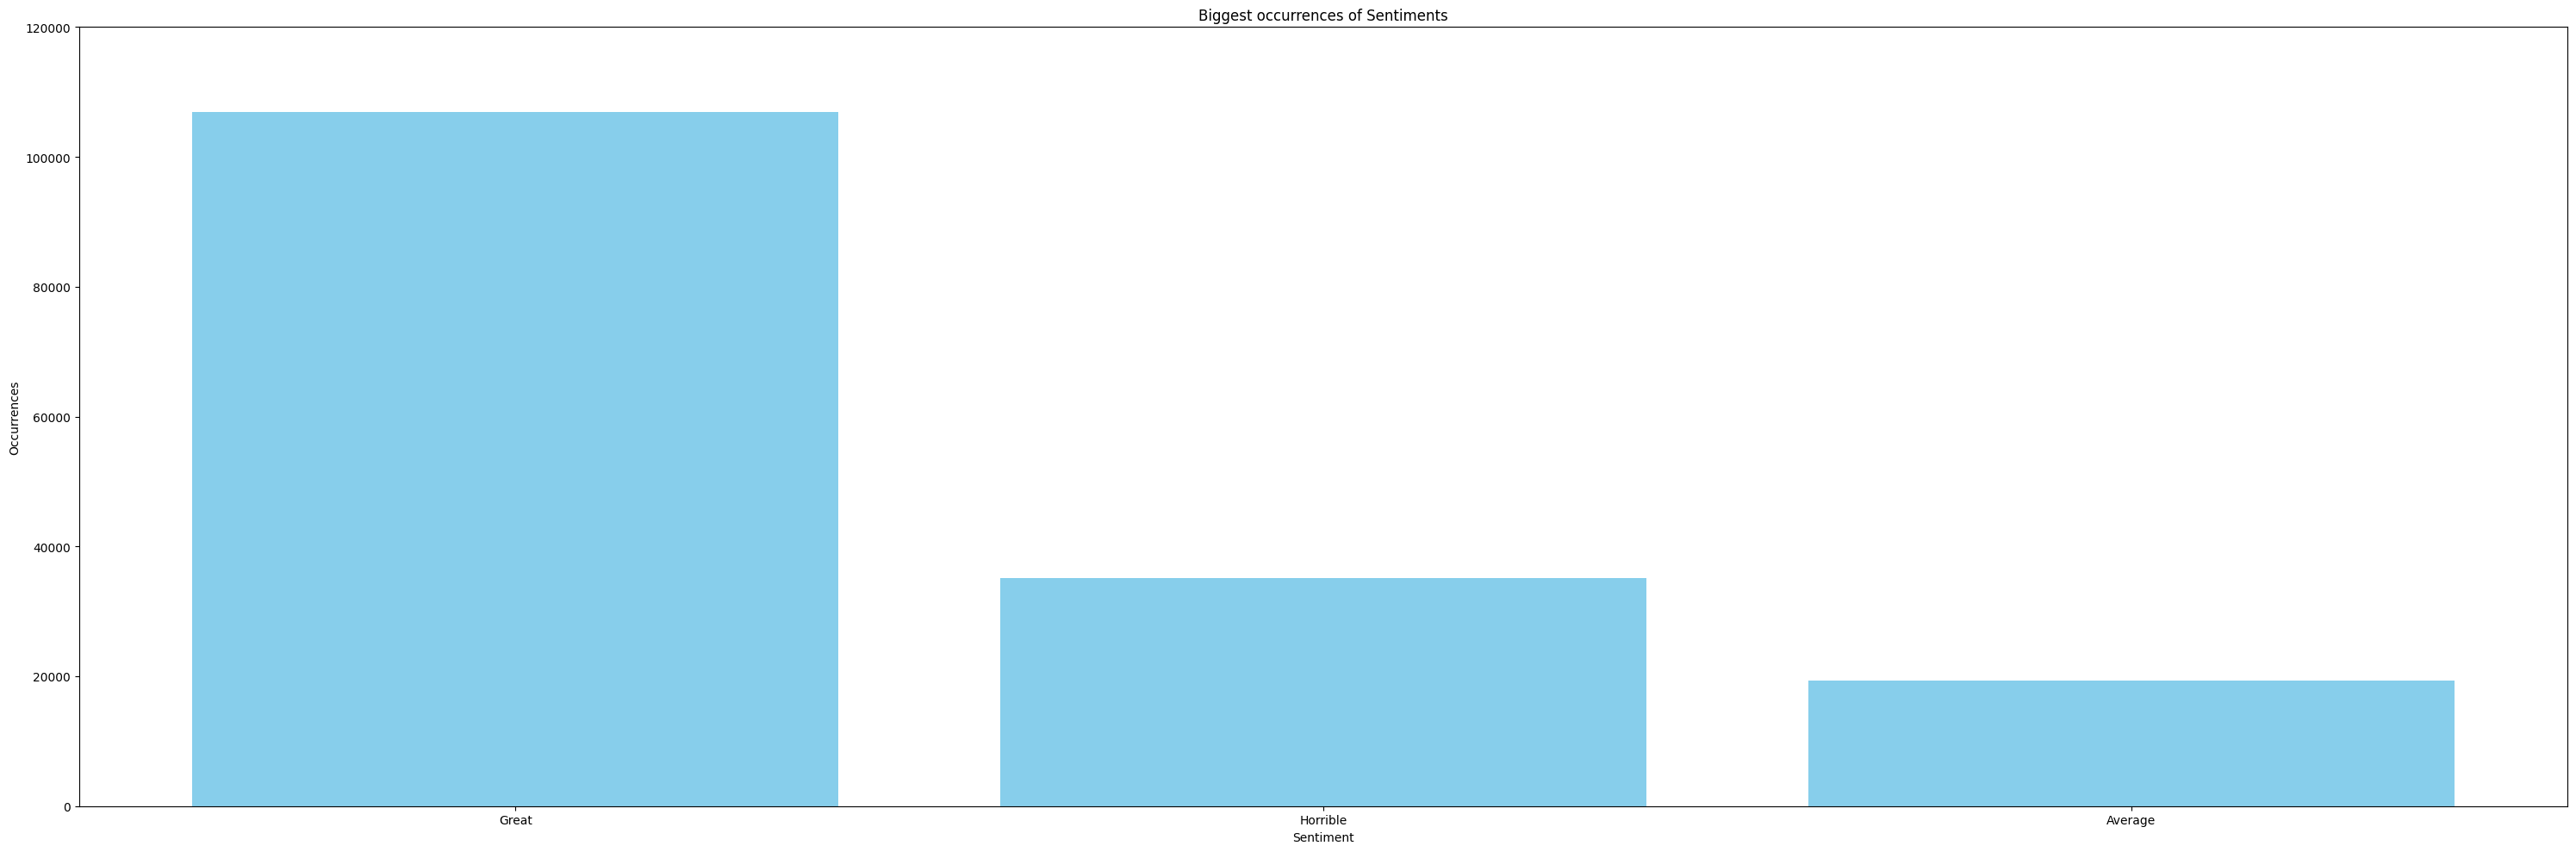

In [ ]:
import matplotlib.pyplot as plt

label_counts = train_df['Sentiment'].value_counts()
label_counts = label_counts.sort_values(ascending=False)

sentiment= label_counts


fig, ax1 = plt.subplots(1, 1, figsize=(30, 10))

ax1.bar(sentiment.index, sentiment.values, color='skyblue')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Occurrences')
ax1.set_title('Biggest occurrences of Sentiments')
ax1.set_ylim(0, max(15, 120000))


plt.tight_layout()
plt.show()

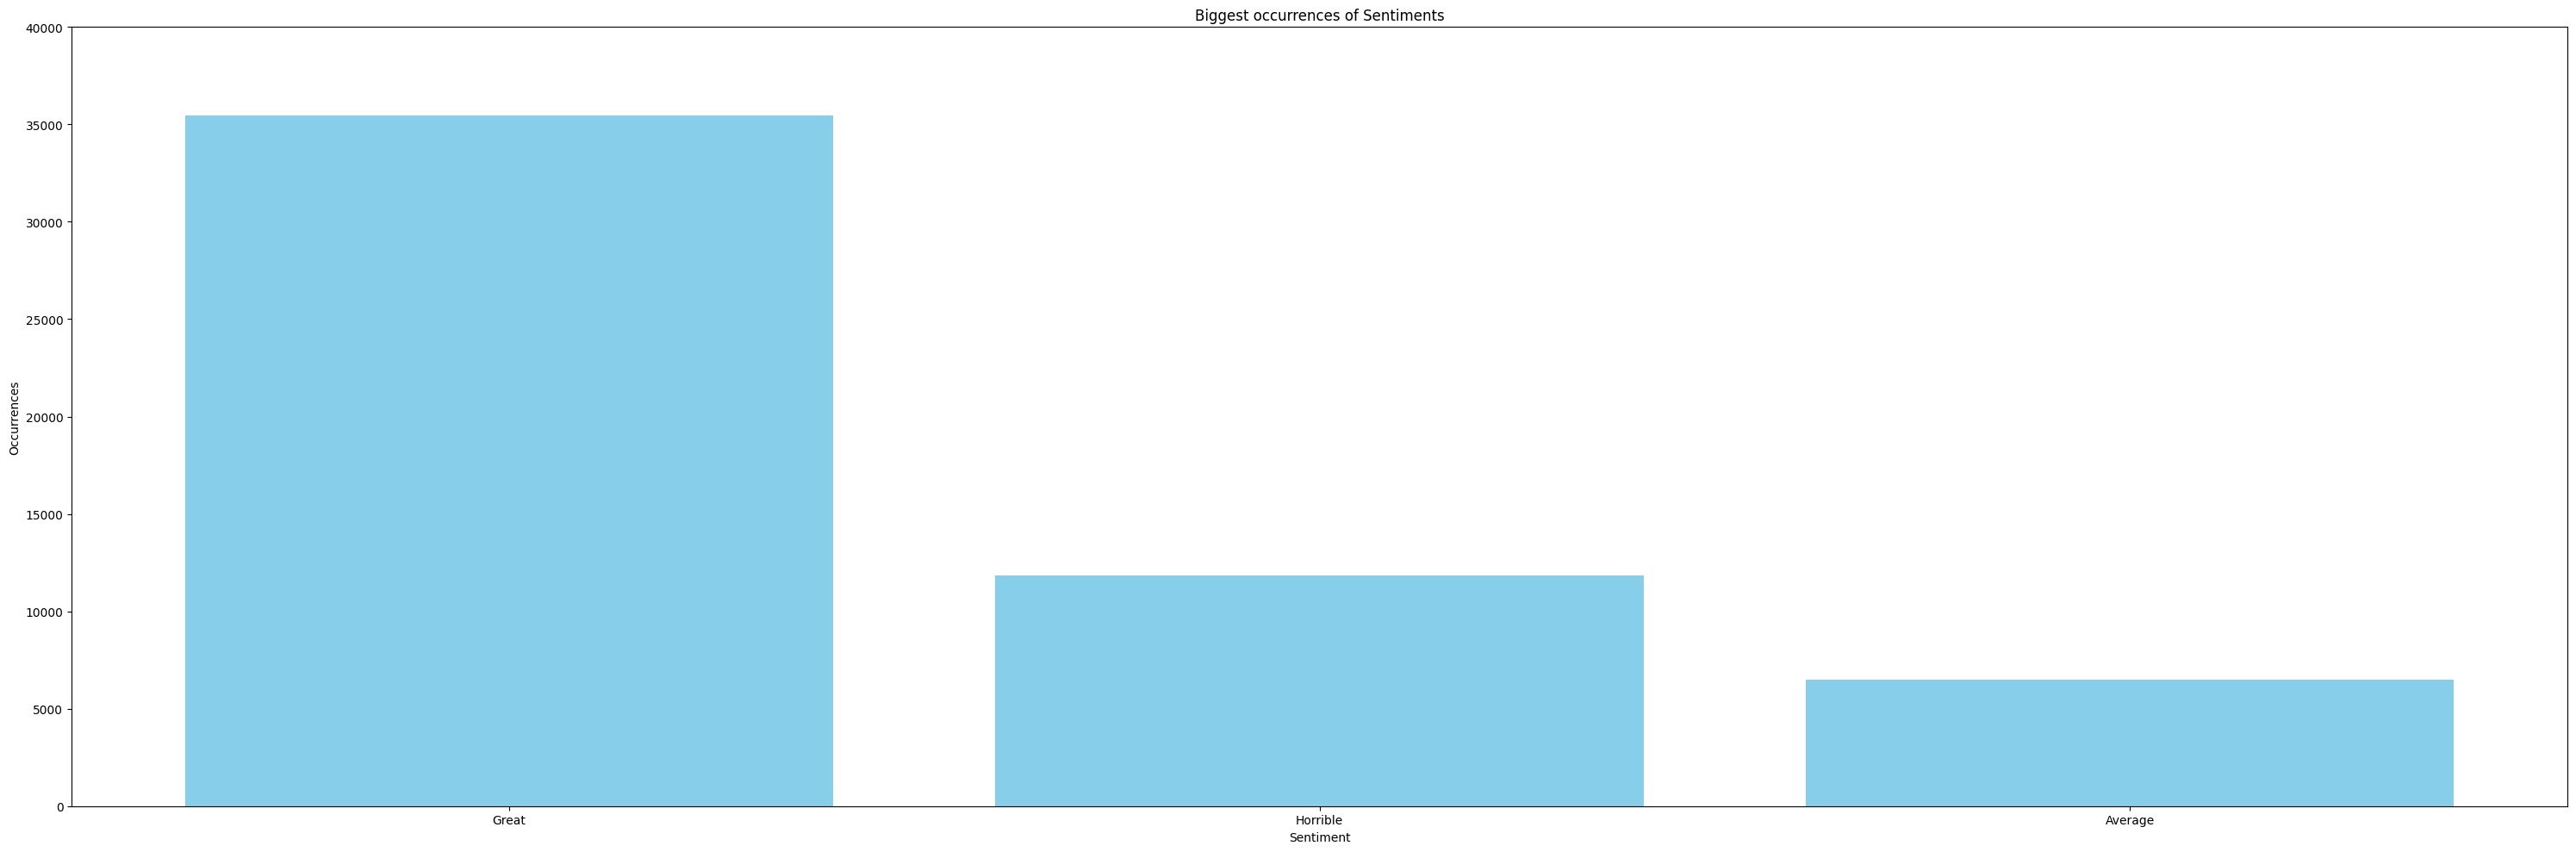

In [ ]:
label_counts = test_df['Sentiment'].value_counts()
label_counts = label_counts.sort_values(ascending=False)

sentiment= label_counts


fig, ax1 = plt.subplots(1, 1, figsize=(30, 10))

ax1.bar(sentiment.index, sentiment.values, color='skyblue')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Occurrences')
ax1.set_title('Biggest occurrences of Sentiments')
ax1.set_ylim(0, max(15, 40000))


plt.tight_layout()
plt.show()

In [ ]:
# From Visualization we can concur there is a large data imbalance that needs to be fixed

# Function to balance Our data
def fix_imbalance(df):
    rest_df = df[df.label != 0]
    great_df=df.query("label == 0").sample(frac=0.4, replace=True, random_state=1)
    balanced_df = pd.concat([rest_df, great_df], axis=0)
    return balanced_df

train_Balanced_df=fix_imbalance(train_df)
test_Balanced_df=fix_imbalance(test_df)

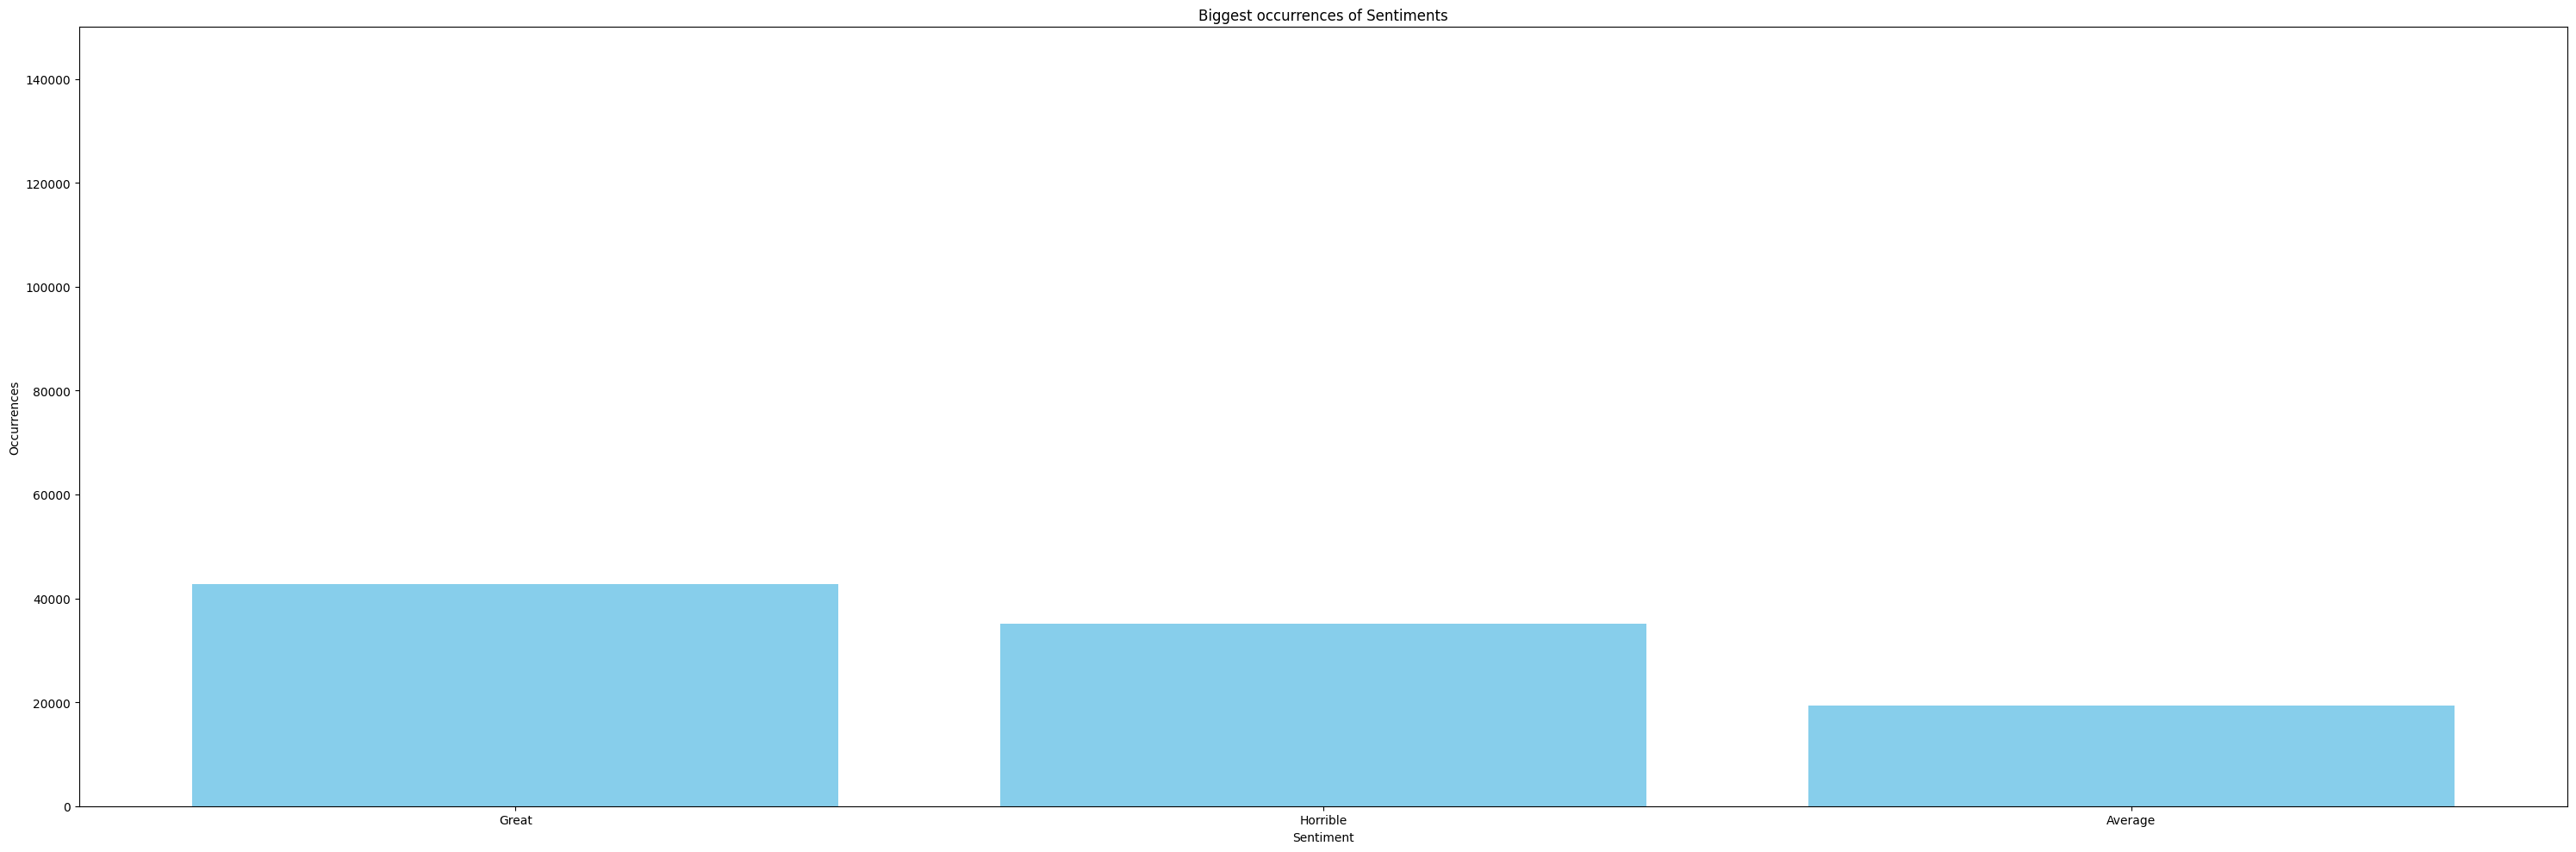

In [ ]:
label_counts = train_Balanced_df['Sentiment'].value_counts()
label_counts = label_counts.sort_values(ascending=False)

sentiment= label_counts


fig, ax1 = plt.subplots(1, 1, figsize=(30, 10))

ax1.bar(sentiment.index, sentiment.values, color='skyblue')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Occurrences')
ax1.set_title('Biggest occurrences of Sentiments')
ax1.set_ylim(0, max(15, 150000))


plt.tight_layout()
plt.show()

### Data Preperation

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer
import torch

In [ ]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
class Preprocessing(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        Review = str(self.data.review[index])
        Review = " ".join(Review.split())
        inputs = self.tokenizer.encode_plus(
            Review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.label[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
train_clean_df,test_clean_df = train_Balanced_df.reset_index(drop=True), test_Balanced_df.reset_index(drop=True)

In [ ]:
training_set = Preprocessing(train_clean_df, tokenizer, MAX_LEN)
testing_set = Preprocessing(test_clean_df, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## DistilBert Model


### Intializing Model

In [ ]:
import transformers
from transformers import DistilBertModel

In [ ]:
# Setting up Hyperparameters
EPOCHS = 1
LEARNING_RATE = 1e-05

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.Linear = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768,len(unique_labels))

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.Linear(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistillBERTClass()
model.to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
#if running on CPU
#checkpoint = torch.load("/content/drive/MyDrive/KBAI model/pytorch_distilbert_drugs.bin",map_location=torch.device('cpu'))

# Load last saved model and optimizer states
checkpoint = torch.load("/content/drive/MyDrive/NLU Project/pytorch_distilbert_drugs.bin")

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# Function to calcuate the accuracy of the model

def Accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

### Training

In [ ]:
def train(epoch):
    tr_loss = 0 # stores accumelative training loss
    n_correct = 0 # stores number of accurate predicions
    nb_tr_steps = 0 # stores number of training steps
    nb_tr_examples = 0 # stores number of samples passed through model at a given time

    model.train() #set model on training mode
    for _,data in enumerate(training_loader, 0):
       # Retrieve token IDs,attention masks and targets from dataloader
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        #passes ids and attention masks through Model
        outputs = model(ids, mask)

        # Uses cross entropy loss to calculate loss between output and target predictions
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() # accumelates loss

        #Applying softmax function on output and calculate number of correct predictions
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += Accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad() #Clears gradient of parameters of latest minibatch to avoid gradient accumilations
        loss.backward() # performs backwards propogation on model parameters using calculated loss
        optimizer.step() # performs optimization step on model

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

Training Loss per 5000 steps: 0.2695775032043457
Training Accuracy per 5000 steps: 100.0
Training Loss per 5000 steps: 0.5486932839476462
Training Accuracy per 5000 steps: 77.31453709258149
Training Loss per 5000 steps: 0.5392952256909285
Training Accuracy per 5000 steps: 77.63723627637236
The Total Accuracy for Epoch 0: 77.80133159080853
Training Loss Epoch: 0.5370845382812055
Training Accuracy Epoch: 77.80133159080853


### Validation

In [ ]:
y_pred = []
y_true = []
def valid(model, testing_loader):
    tr_loss = 0
    n_correct = 0
    n_wrong = 0
    nb_tr_steps=0
    nb_tr_examples=0

    model.eval()
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += Accuracy(big_idx, targets)

            y_pred.extend(big_idx.data.cpu().numpy())
            y_true.extend(targets.data.cpu().numpy())

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

Validation Loss per 100 steps: 0.1790788173675537
Validation Accuracy per 100 steps: 100.0
Validation Loss per 100 steps: 0.660984310778046
Validation Accuracy per 100 steps: 73.47030593881223


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in unique_labels],
                     columns = [i for i in unique_labels])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

### Inference

In [ ]:
def inference(model,text):
    clean_text = preprocess(text) # preprocess data to pass it into tokenizer

    model.eval()

    #tokenizing text to process it into model
    input = tokenizer.encode_plus(
            clean_text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
    #transform data into tensor objects
    ids = torch.tensor(input['input_ids'], dtype=torch.long)
    mask = torch.tensor(input['attention_mask'], dtype=torch.long)

    with torch.no_grad():
      ids = ids.to(device, dtype = torch.long)
      mask = mask.to(device, dtype = torch.long)
      output = model(ids, mask)
      _,index=torch.max(output.data, dim=1)

    value = {i for i in value_pair if value_pair[i]==index.item()}

    return value.pop()

### Saving Model

In [ ]:
output_model_file = '/content/drive/MyDrive/NLU Project/pytorch_distilbert_drugs.bin'

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, output_model_file)